In [125]:
import tonic

root = "/Users/matteogiardina/Desktop/BEMACS 2/SNNs/BainsaSNNs/N-MNIST/n-mnist_data"

train_ds = tonic.datasets.NMNIST(save_to=root, train=True)
test_ds = tonic.datasets.NMNIST(save_to=root, train=False)

In [126]:
events, target = train_ds[50000]

In [127]:
print(events)

[(16,  6,    590, 1) (16, 22,   1353, 1) ( 8, 13,   1774, 0) ...
 ( 3, 18, 306365, 1) (14, 13, 307274, 0) (12,  9, 309172, 1)]


each 4D vector has (x, y, t, p) where
* x and y are coordinates 34x34
* t is the timestamp of the event recorded (incrase or decrease in brightness) 0-300 000 microseconds == 0 - 300 milliseconds (ms)
* p is polarity, 1 = on-spike = increase in brightness, 0 = off-spike = decrease in spike


In [128]:
len(events) # is variable ~5000

5857

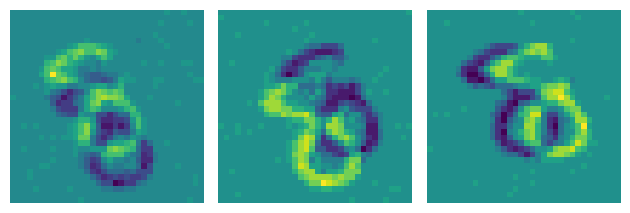

In [129]:
tonic.utils.plot_event_grid(events)
# automatically divides the vectors for 3 time intervals (the 3 saccades) that is why it plots 3 images 0-100, 100-200, 200-300 ms

Neural Networks can't take lists of events as input, so we must convert them into usable format --> tensors

Moreover, if we keep the time range, 0 - 300 000 microseconds, the tensor is too large and sparse, hence we bin the time in less categories, each of size 1000 microseconds.

300 000 / 1000 = 300 temporal bins (categories)

By this technique we lose temporal precision but we can work with a more dense format

Denoise removes isolated events --> if no event occurs within a neighborhood of 1 pixel (looks at x = ± 1 and y = ± 1) across filter time (=10 000), then the event is filtered if none of the changes checked has a 1 as polarity


In [130]:
import tonic.transforms as transforms
sensor_size = tonic.datasets.NMNIST.sensor_size

frame_transform = transforms.Compose(
    [transforms.Denoise(filter_time = 10000),
     transforms.ToFrame(sensor_size = sensor_size, time_window = 1000)])

Load again, but this time with a the transforms applied

In [131]:
trainset = tonic.datasets.NMNIST(save_to=root, transform = frame_transform, train=True)
testset = tonic.datasets.NMNIST(save_to=root, transform = frame_transform,train=False)

For training purposes, we use cache

Moreover, we use a "collation" function that allows us to uniform all samples' sizes

In [132]:
from torch.utils.data import DataLoader
from tonic import DiskCachedDataset

cached_trainset = DiskCachedDataset(trainset, cache_path = "./cache/nmnist/train")
cached_dataloader = DataLoader(cached_trainset)

batch_size = 128
trainloader = DataLoader(cached_trainset,
                         batch_size = batch_size,
                         collate_fn = tonic.collation.PadTensors)

def load_sample_batched():
    events, target = next(iter(cached_dataloader))

load_sample_batched()

### Train the Network

Start by defining caching wrappers and dataloaders

Also applying data augmentation

Given the samples we get from the cace are frames, we can use PyTorch Vision to appy whatever random transform we like

* torch.from_numpy simply transforms a np array into a torch tensor
* RandomRotation applies a random rotation up to ±10 degrees, tilting the digit. Hence, making the model more robust to recoginizing also rotated digits

    * Why this transformation in particular and not some other? Because it would make no sense for example flipping a number becasue it could totally change it, hence we lose the meaning, while the slight tilting helps the model be more robust and flexible to real-world scenarios
    * Why don't we also augment "test set"? Because they are our evaluation samples, to measure true performance of the model

In [133]:
import torch
import torchvision

transform = tonic.transforms.Compose([torch.from_numpy,
                                      torchvision.transforms.RandomRotation([-10,10])])

cached_trainset = DiskCachedDataset(trainset, transform=transform, cache_path = "./cache/mnist/train")
# No augmentation (transform) for the test set
cached_testset = DiskCachedDataset(testset, cache_path = "./cache/mnist/train")

batch_size = 128
trainloader = DataLoader(cached_trainset, batch_size = batch_size,
                         collate_fn = tonic.collation.PadTensors(batch_first = False), shuffle = True)
testloader = DataLoader(cached_testset, batch_size = batch_size,
                        collate_fn = tonic.collation.PadTensors(batch_first = False))

We will get a 5D tensor (timestep, batch_size, polarity, x, y)

Think of each digit (batch = 1) at timestep t, represented by a 3d tensor (2, 34, 34) basically showing whether at timestep t, at each pixel (x,y) if there has been an increase or decrease of brightness

In [134]:
event_tensor, target = next(iter(trainloader))
print(event_tensor.shape)

torch.Size([310, 128, 2, 34, 34])


### Defining the Network

Use snnTorch + PyTorch to construct a CSNN

The architecture is 12C5 - MP2 - 32C - MP2 - 800FC10
* 12C5 is a 5x5 convolutional kernel with 12 filters
* MP2 is a 2x2 max-pooling function
* 800FC10 is a fully-connected layer that maps 800 neurons to 10 outputs (digits)

In [135]:
import snntorch as snn
# import snntorch as surrogate
from snntorch import surrogate
from snntorch import functional as SF
from snntorch import spikeplot as splt
from snntorch import utils
import torch.nn as nn

Set the device to train the nn on, in my case mps is Metal Performance Shaders --> specific of macbooks with > M1

In [136]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

We define the surrogate gradient function

Given the Heaviside step function (for a reset if memberane potential exceeds threshold), we replace it with the arctangent function in the backward pass, used only during backpropagation

Beta is the decay rate of the neuron's membrane potential --> How fast the membrane potential decays when there is no spike input

Beta -> 0 is a fast decasy ---- Beta -> 1 is a slow decay

In [137]:
spike_grad = surrogate.atan()
#  by default, its argument alpha = 2, controls the steepness of the curve

beta = 0.5

Initialize the network with the previously specified architecture

In [138]:
net = nn.Sequential(
    nn.Conv2d(2,12,5),
    nn.MaxPool2d(2),
    snn.Leaky(beta = beta, spike_grad = spike_grad, init_hidden = True),
    nn.Conv2d(12,32,5),
    nn.MaxPool2d(2),
    snn.Leaky(beta = beta, spike_grad = spike_grad, init_hidden = True),
    nn.Flatten(),
    nn.Linear(32*5*5, 10),
    snn.Leaky(beta = beta, spike_grad = spike_grad, init_hidden = True, output = True)
    ).to(device)

Initalize the forward pass function

spk_out, mem_out = ... because the Leaky outputs two values, but we don't need the membrane (indeed we don't keep track of it)

In [139]:
def forward_pass(net, data):
    spk_rec = []
    utils.reset(net) # resets hidden states for all LIF neurons before starting the pass

    for step in range(data.size(0)): # data.size(0) is the first dimension == number of timesteps
        spk_out, mem_out = net(data[step])
        spk_rec.append(spk_out)

    return torch.stack(spk_rec)

### Training the NN

We could use Cross Entropy Loss to the total spike count, to maximize the numner of spikes from the correct class

In this case we are using Mean Square Error Spike Count Loss, which aims to elicit spikes from the correct class 80% of the time, and 20% of the time from incorrect classes. This is done to encourage incorrect neurons to fire, in order to avoid dead neurons.

In [140]:
optimizer = torch.optim.Adam(net.parameters(), lr = 2e-2, betas = (0.9, 0.999))
loss_fn = SF.mse_count_loss(correct_rate = 0.8, incorrect_rate = 0.2)

Training on neuromorphic data is expensive as it requires sequentially iterating through many time steps (~300 timesteps in the N-MNIST dataset)

We'll just do 50 iterations, which is 1/10th of an epoch

1 epoch = 1 full pass on the training dataset

Given training set has 60k samples and our batch_size = 128, then 1 epoch = 60k/128 ~ 470 iterations (gradient steps)

So 1/10th of an epoch is 47 (~50)

In [141]:
num_epochs = 1 # never reaching it
num_iters = 50

loss_hist = []
acc_hist = []

for epoch in range(num_epochs):
    for i, (data, targets) in enumerate(iter(trainloader)):
        data = data.to(device)
        targets = targets.to(device)

        net.train()
        spk_rec =  forward_pass(net, data)
        loss_val = loss_fn(spk_rec, targets)

        # Gradient calculation + weights update
        optimizer.zero_grad() # resets the gradients of the previous iteration
        loss_val.backward()
        optimizer.step()

        # Store the loss in the history for plotting purposes
        loss_hist.append(loss_val.item())

        print(f"Epoch {epoch}, Iteration {i} \nTrain Loss: {loss_val.item():.2f}")

        acc = SF.accuracy_rate(spk_rec, targets)
        acc_hist.append(acc)
        print(f"Accuracy: {acc*100:.2f}%\n")

        # Training loop breaks after 50 iterations
        if i == num_iters:
            break

Epoch 0, Iteration 0 
Train Loss: 30.90
Accuracy: 7.03%

Epoch 0, Iteration 1 
Train Loss: 30.96
Accuracy: 13.28%

Epoch 0, Iteration 2 
Train Loss: 31.00
Accuracy: 13.28%

Epoch 0, Iteration 3 
Train Loss: 27.44
Accuracy: 10.16%

Epoch 0, Iteration 4 
Train Loss: 13.89
Accuracy: 8.59%

Epoch 0, Iteration 5 
Train Loss: 16.62
Accuracy: 14.06%

Epoch 0, Iteration 6 
Train Loss: 19.72
Accuracy: 12.50%

Epoch 0, Iteration 7 
Train Loss: 18.02
Accuracy: 14.06%

Epoch 0, Iteration 8 
Train Loss: 14.59
Accuracy: 14.06%

Epoch 0, Iteration 9 
Train Loss: 11.82
Accuracy: 14.84%

Epoch 0, Iteration 10 
Train Loss: 15.56
Accuracy: 14.06%

Epoch 0, Iteration 11 
Train Loss: 13.84
Accuracy: 13.28%

Epoch 0, Iteration 12 
Train Loss: 12.70
Accuracy: 15.62%

Epoch 0, Iteration 13 
Train Loss: 12.58
Accuracy: 24.22%

Epoch 0, Iteration 14 
Train Loss: 13.12
Accuracy: 32.81%

Epoch 0, Iteration 15 
Train Loss: 13.05
Accuracy: 32.03%

Epoch 0, Iteration 16 
Train Loss: 12.98
Accuracy: 30.47%

Epoch 0, 

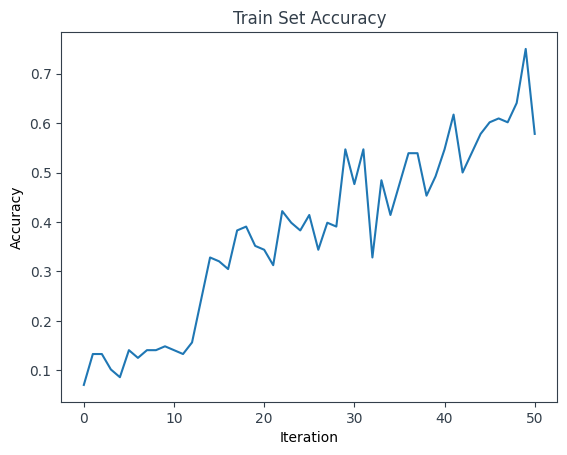

In [142]:
import matplotlib.pyplot as plt

# Plot Loss
fig = plt.figure(facecolor="w")
plt.plot(acc_hist)
plt.title("Train Set Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.show()

In [143]:
# spk_rec = forward_pass(net, data)

In [144]:
# from IPython.display import HTML

# idx = 0

# fig, ax = plt.subplots(facecolor='w', figsize=(12, 7))
# labels=['0', '1', '2', '3', '4', '5', '6', '7', '8','9']
# print(f"The target label is: {targets[idx]}")

# # plt.rcParams['animation.ffmpeg_path'] = 'C:\\path\\to\\your\\ffmpeg.exe'

# #  Plot spike count histogram
# anim = splt.spike_count(
#     spk_rec[:, idx].detach().cpu(),
#     fig, ax,
#     labels=labels,
#     animate=True,
#     interpolate=1
# )


# HTML(anim.to_html5_video())
# # anim.save("spike_bar.mp4")